# Explore Audio Clip Extraction

The neural net model we want to end up with will listen to live audio (from the host device's microphone) to identify, in real-time, which musical notes are being played.

To do this, we'll feed it small buffers of audio as we receive them from the audio API. Typical buffer sizes range from a few hundred to a few thousand audio samples. Traditionally, the buffer size is some power of two.

---

### Terminology sidebar: "sample"

When discussing the training of a neural net, a *sample* is entry from a training or testing data set. These are sometime called "feature vectors". In the context of MAPS, it is one .wav file, with its partnter .txt and .mid files.

When discussing digital audio, a *sample* represent the amplitude of a digitised sound at a particular time. For example, a digitising *sample rate* of 44,100Hz would result in 44,100 *samples* every second.

We can usually tell from context which meaning of the world "sample" is intended, but - when needed - we can use **feature sample** and **audio sample** to disambiguate.

---

## Web Audio API audio format

When working with the Web Audio API:

1. We can choose the sample rate we would like.
2. We can choose to receive mono or stereo data.
3. Audio samples are stored as floats ranging from -1 to +1.

Because note detection doesn't need stero - and to reduce processing - we'll ask the API for mono data.


## MAPS audio format

According to the MAPS documentation:

1. MAPS feature samples have been digitised at 44,100Hz.
2. They are stereo. That is, they contain two "channels" of audio data.
3. Each audio sample is stored as a signed, 16-bit integer.

Also, when we use `scipy.io.wavfile.read` to read the .wav files, the stereo channels are interleaved. In other words, three audio samples from the left and right channels are stored as `[[L0, R0], [L1, R1], [L2, R2]`.

## Our preferred audio format

The highest note on an 88-key piano is C8. This note has a frequency of approximately 4.2 kHz. By the [Nyquist–Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), we need a sample rate of 8.4 kHz or higher to accurately capture C8's fundamental frequency.

It is tempting to use a low sample rate, to reduce the computational load of note detection, but it is important to remember that the note's harmonics carry a lot of useful information as well. C8's third harmonic (16.8 kHz) needs a sample rate of more than 32 kHz to capture accurately.

So - for now, we will use:

1. The MAPS sample rate of 44,100 Hz
2. One of the stereo channels
3. Audio samples stored as floats ranging from -1 to +1.


# Changes to make to `samples/maps.py`

`read_samples` currently returns samples looking like this:

```
{'instrument': 'ENSTDkAm',
 'sample': 'MAPS_ISOL_NO_F_S0_M100_ENSTDkAm',
 'sample_rate': 44100,
 'audio': array([[ 1,  9],
        [ 0,  7],
        [-1,  7],
        ...,
        [19, 19],
        [18, 17],
        [18, 18]], dtype=int16),
 'notes': [{'onset': '0.51599', 'offset': '2.521', 'midi_pitch': '100'}]}
```

## Channels

To easily extract one channel of audio from the MAPS samples, `read_sample` must be modified to *transpose* the audio data from `[[L0, R0], [L1, R1], [L2, R2]` to `[[L0, L1, L2]. [R0, R1, R2]]`.


In [1]:
import numpy as np

audio = np.array([[ 1,  9],
        [ 0,  7],
        [-1,  7],
        [19, 19],
        [18, 17],
        [18, 18]])

print(audio)

[[ 1  9]
 [ 0  7]
 [-1  7]
 [19 19]
 [18 17]
 [18 18]]


In [2]:
audio = audio.transpose()
print(audio)

[[ 1  0 -1 19 18 18]
 [ 9  7  7 19 17 18]]


## Value ranges

As mentioned, the audio samples in the MAPS .wav files are signed, 16-bit integers. This means that the amplitudes are in the range -32,768 to +32,767.

We need to tarnsform them to flots in the range -1 to +1.

To do this, we simply divide by $2^{15} = 32,768$

In [3]:
audio / 2**15

array([[ 3.05175781e-05,  0.00000000e+00, -3.05175781e-05,
         5.79833984e-04,  5.49316406e-04,  5.49316406e-04],
       [ 2.74658203e-04,  2.13623047e-04,  2.13623047e-04,
         5.79833984e-04,  5.18798828e-04,  5.49316406e-04]])

## Onset and offset times

MAPS note data records onset and offset times in seconds. For our purposes, an audio sample index is more useful than a time value.

We'll define a function `time_to_index` to do this conversion for us. Time values are expressed in seconds, with fractional values. Audio sample indices must be strictly integral. I find it useful to round onset times *up* and offset times *down*, so `time_to_index` will take an optional third parameter specifying the rounding function to be used.

In [4]:
import math

def time_to_index(sample_rate, seconds, round_function = round):
    return round_function(sample_rate * seconds)

note = {'onset': '0.51599', 'offset': '2.521', 'midi_pitch': '100'} # taken from the example above

sample_rate = 44100
onset_time = float(note['onset'])
onset_index = time_to_index(sample_rate, onset_time, math.ceil)

offset_time = float(note['offset'])
offset_index = time_to_index(sample_rate, offset_time, math.floor)

print("onset: {0}s => audio[{1}]".format(onset_time, onset_index))
print("offset: {0}s => audio[{1}]".format(offset_time, offset_index))

onset: 0.51599s => audio[22756]
offset: 2.521s => audio[111176]


## Note numbers

MAPS (*MIDI* Aligned Piano Sounds) is, as the name says, MIDI based. They use MIDI pitch numbers to represent notes.

In the Javascript libraries I've been developing for this project, I use a different numbering system.

The function `midi_pitch_to_note_index` will do this translation for us.

In [5]:
def midi_pitch_to_note_index(midi_pitch):
    # The note C0 has a MIDI pitch number of 12
    # Within my music library, C0 has a "note index" of 1
    # Both systems count in semitones, so there is a simple difference of 11 between them.
    return midi_pitch - 11

# Audio sample window sizes

As mentioned above, we'll be receiving small buffers of audio from the Web Audio API.

These buffers are also called windows, and are what we'll be feeding into the neural net for note identification.

We need to determine the best window size to use.

The lowest note we are interested in is the "bottom" note of an 88-key piano. This is note the A0, with a fundamental frequency of 27.5 Hz.

In [6]:
sample_rate = 44100
lowest_note_freq = 27.5

lowest_note_period = 1 / lowest_note_freq

print("A0 period:")
print("{0} seconds".format(lowest_note_period))
print("{0} samples".format(lowest_note_period * sample_rate))

A0 period:
0.03636363636363636 seconds
1603.6363636363635 samples


The period of A0's fundamental is about 0.036 seconds, or about 1604 audio samples.

Any higher note would have a shorter period, so 1604 samples is enough to capture at least one full period of any piano note.

To keep the app feeling responsive, we would like it to respond to a note or chord being played within about a tenth of a second.

In [7]:
max_window_seconds = 0.1
max_window_samples = round(max_window_seconds * sample_rate)

print("{0} second => {1} samples".format(max_window_seconds, max_window_samples))

0.1 second => 4410 samples


So the minimum window size we need is 1604 samples (0.036s), and the maximum we want is 4410 samples (0.1s)

This gives us 2048 and 4096 as possible window sizes (remembering that window sizes should be a power of 2).

For now, we'll use 4096 to have the best chance of success. Once we have a working model, we can try 2048 to see if it works as well as 4096 does.

In [8]:
window_samples = 4096

# Extracting clips for training

Eventually, we'll have some fancy clip extraction which extracts random portions of the audio data and which handles multiple notes being played simultaneously.

For now - just to get started with a basic model - we'll only handle single notes, and will always extract a clip starting at the exact onset of the note.

The function `get_onset_clip` will do this basic extraction.

In [9]:
from samples.maps import read_samples as read_maps_samples

sample = next(read_maps_samples('/datasets/audio/maps'))

def get_onset_clip(sample, channel, window_size):
    assert len(sample['notes']) == 1
    note = sample['notes'][0]
    onset_index = note['onset']
    
    window = sample['audio'][channel][onset_index:onset_index + window_size]
    return {'note': note['note_index'], 'window': window}


clip = get_onset_clip(sample, 0, window_samples)

print(clip)

{'note': 89, 'window': array([-0.0012207 , -0.00137329, -0.00146484, ..., -0.03356934,
       -0.02099609, -0.00769043])}


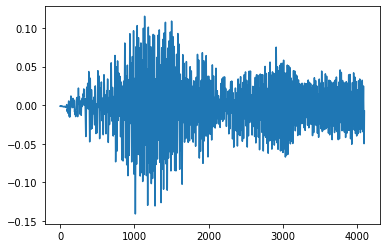

In [10]:
import pylab

pylab.plot(range(window_samples), clip['window'])